# Further inspection of recordings showed a third frequency group

#### Before taking more sophisticated approaches towards frequency-based clustering, I felt it would be good to establish a few example recordings represetative of the kinds of frequencies I have observed.

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

In [4]:
site_key = 'Central'
freq_key = ''

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000
print(f'Looking at {fig_details["site_name"]}')

Looking at Central Pond


### Below, red and yellow detections were both originally clustered together as HF calls.
### Blue detections were originally clustered together as LF calls

#### **A white dashed line has been included to show a potential frequency threshold to separate the yellow and red group.**
#### **Calls with min. frequency >= 43000 have been put into the yellow group.**
#### **As an update to the previous notebook, calls with min. frequency >= 35000 have been put into the red group**

In [5]:
def plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, plot_region):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']


    if data_params['site_key'] == 'Central':
        blue_l_bound = 20000
        blue_u_bound = 50000
        red_l_bound = 34000
        red_u_bound = 74000
        yellow_l_bound = 42000
        yellow_u_bound = 92000

    if data_params['site_key'] == 'Telephone':
        blue_l_bound = 20000
        blue_u_bound = 50000
        red_l_bound = 30000
        red_u_bound = 78000
        yellow_l_bound = 41000
        yellow_u_bound = 102000

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])
    if plot_region != '':
        if plot_region == 'yellow':
            plt.fill_between(x=np.linspace(0, duration*(fs/2), 11), y1=yellow_l_bound/(fs/2), y2=yellow_u_bound/(fs/2), color='yellow', linewidth=2, alpha=0.5)
        if plot_region == 'red':
            plt.fill_between(x=np.linspace(0, duration*(fs/2), 11), y1=red_l_bound/(fs/2), y2=red_u_bound/(fs/2), color='red', linewidth=2, alpha=0.5)
        if plot_region == 'blue':
            plt.fill_between(x=np.linspace(0, duration*(fs/2), 11), y1=blue_l_bound/(fs/2), y2=blue_u_bound/(fs/2), color='cyan', linewidth=2, alpha=0.5)
    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Group 1')
    red_patch = patches.Patch(facecolor='red', edgecolor='k', label='Group 2')
    blue_patch = patches.Patch(facecolor='cyan', edgecolor='k', label='Group 3')
    legend_patches = [yellow_patch, red_patch, blue_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        if row['low_freq'] >= yellow_l_bound and row['high_freq'] <= yellow_u_bound:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        elif row['low_freq'] >= red_l_bound and row['high_freq'] <= red_u_bound:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='red', facecolor='none', alpha=0.8)
        elif row['low_freq'] >= blue_l_bound and row['high_freq'] <= blue_u_bound:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='cyan', facecolor='none', alpha=0.8)
        else:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='yellowgreen', facecolor='none', alpha=0.8)
        ax.add_patch(rect)
    plt.yticks(ticks=np.linspace(0, 1, 7), labels=np.linspace(0, fs/2000, 7).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.xlim(0, duration*(fs/2))
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)), loc='upper right')

    plt.tight_layout()
    plt.show()

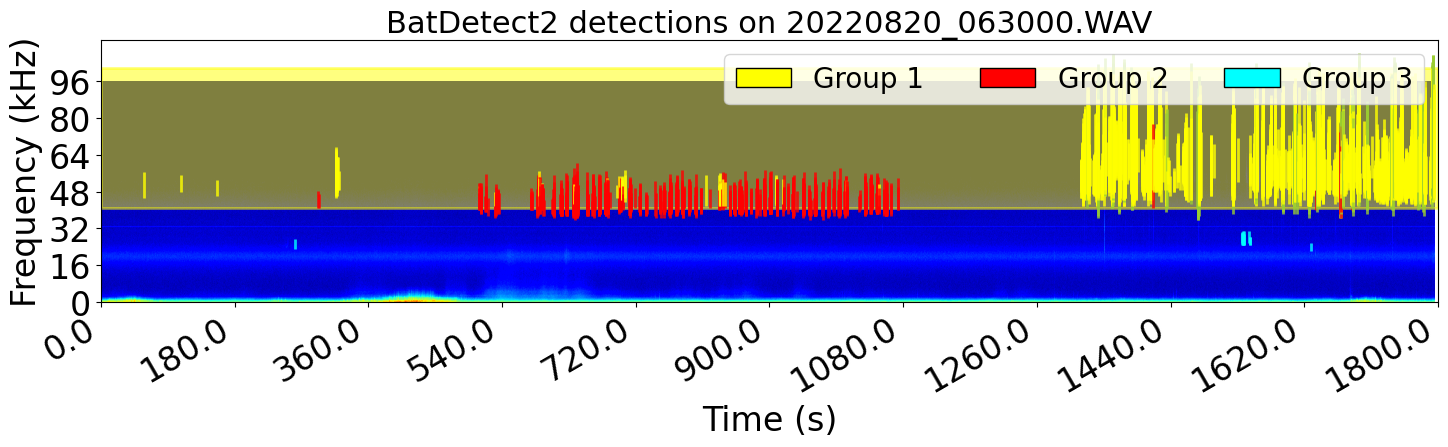

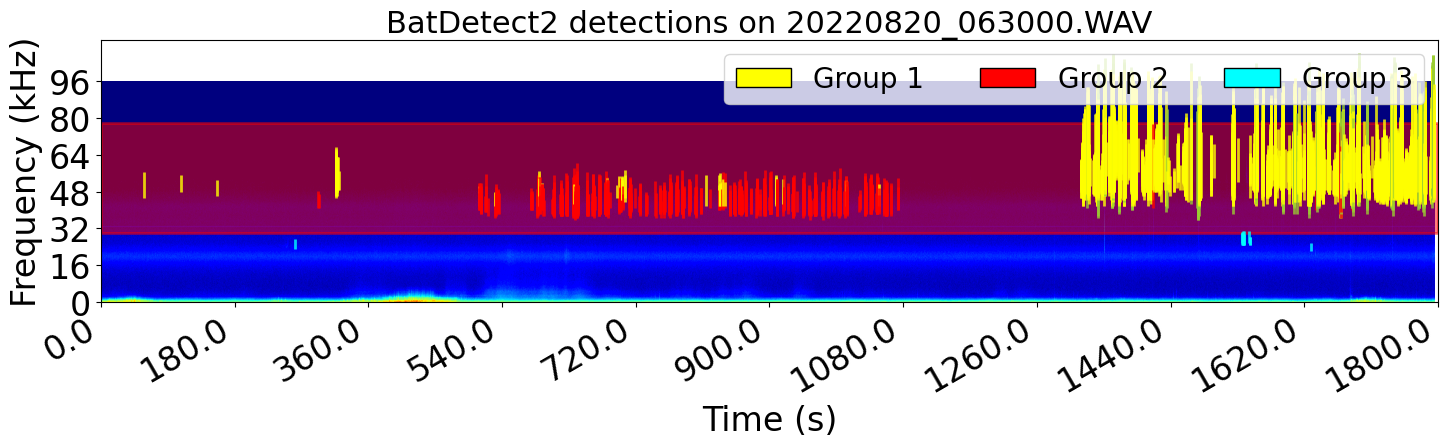

In [6]:
filename = '20220820_063000'
filepath_key = f'UBNA_001/{filename}'
reduce = 55
file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
data_params = dict()
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]
data_params['site_key'] = 'Telephone'
data_params['site_name'] = SITE_NAMES[data_params['site_key']]
spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)

for start in np.arange(0, 1800, 1800):
    duration = 1800
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB
    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration
    spec_features['vmin'] = vmin
    plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]
    plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, 'yellow')
    plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, 'red')

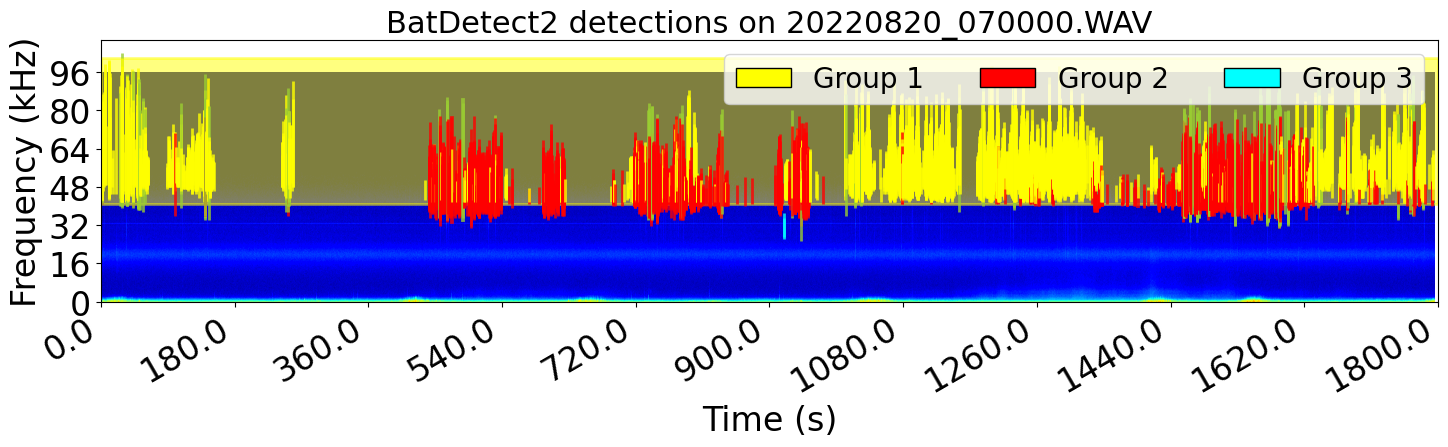

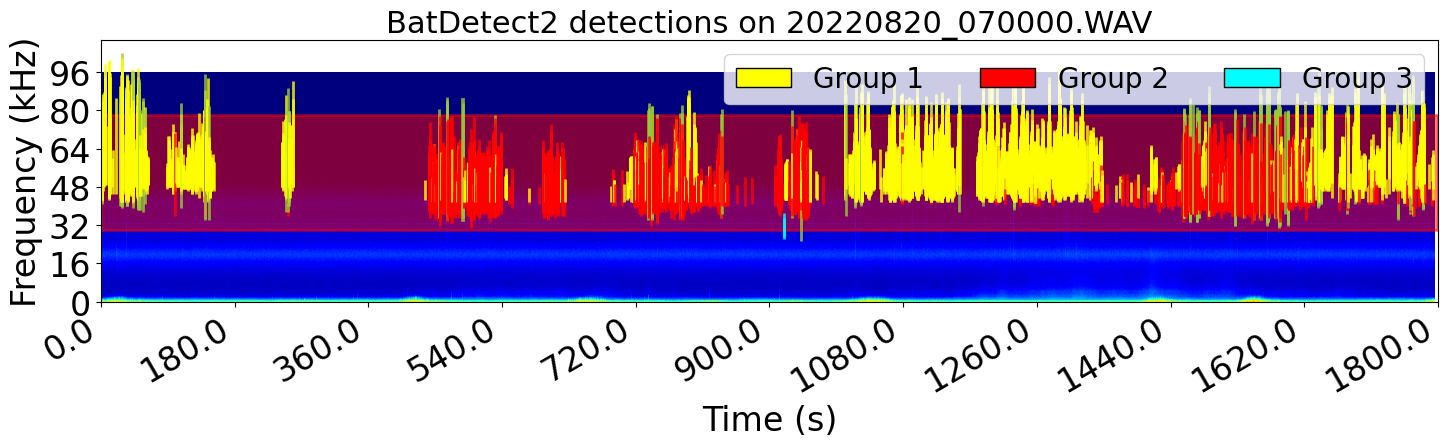

In [7]:
filename = '20220820_070000'
filepath_key = f'UBNA_001/{filename}'
reduce = 55
file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
data_params = dict()
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]
data_params['site_key'] = 'Telephone'
data_params['site_name'] = SITE_NAMES[data_params['site_key']]
spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)

for start in np.arange(0, 1800, 1800):
    duration = 1800
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB
    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration
    spec_features['vmin'] = vmin
    plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]
    plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, 'yellow')
    plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, 'red')

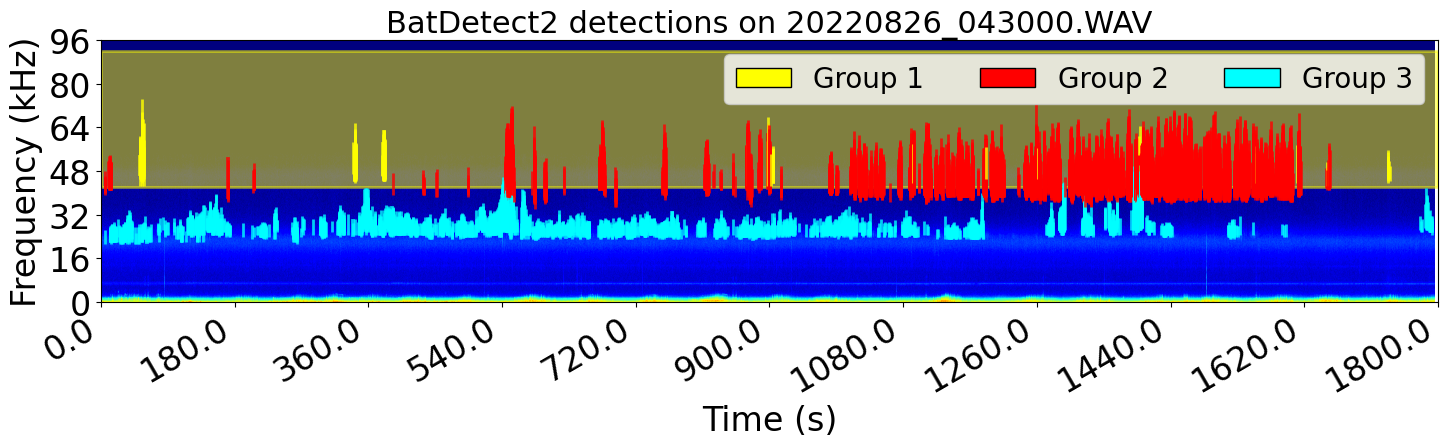

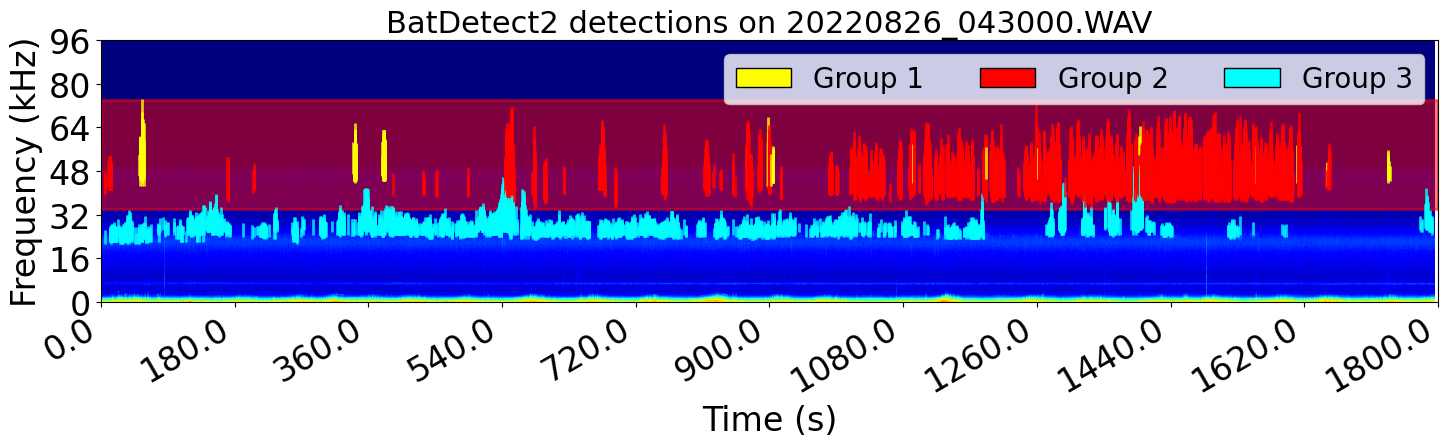

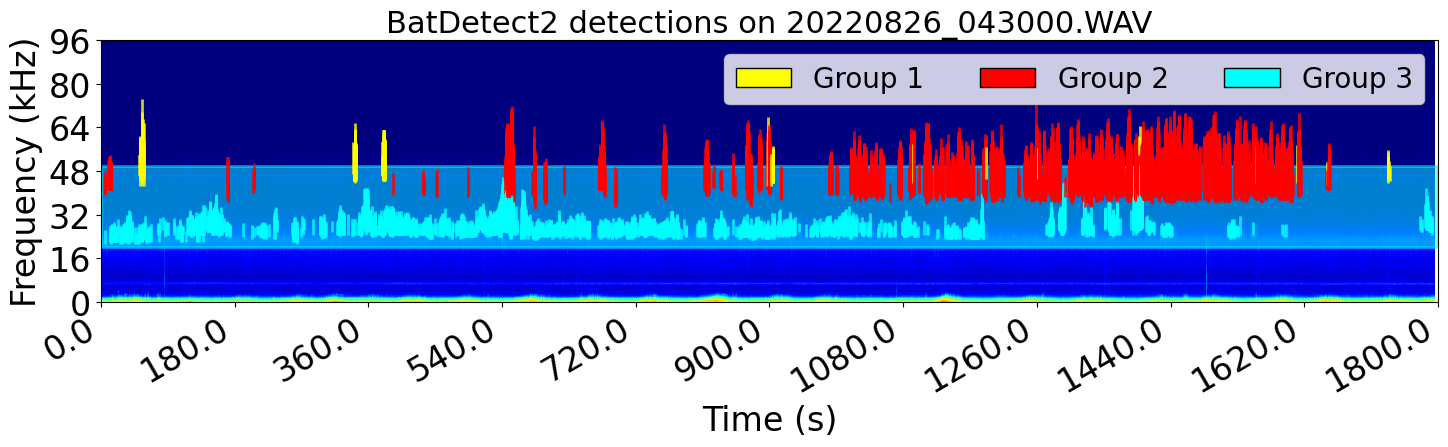

In [8]:
filename = '20220826_043000'
filepath_key = f'UBNA_010/{filename}'
reduce = 55
file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
data_params = dict()
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]
data_params['site_key'] = 'Central'
data_params['site_name'] = SITE_NAMES[data_params['site_key']]
spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)

for start in np.arange(0, 1800, 1800):
    duration = 1800
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB
    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration
    spec_features['vmin'] = vmin
    plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]
    plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, 'yellow')
    plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, 'red')
    plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, 'blue')

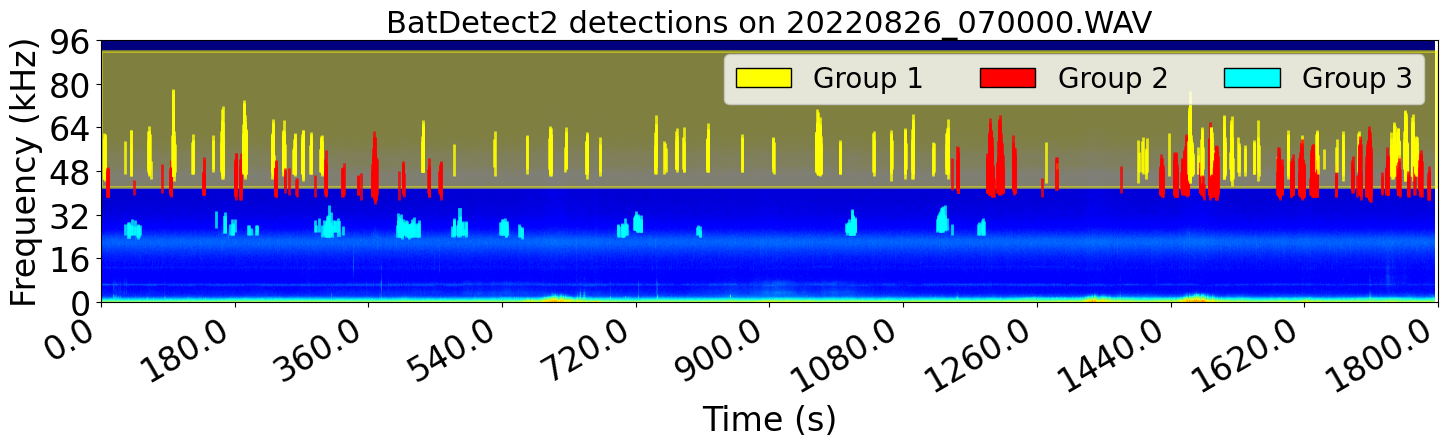

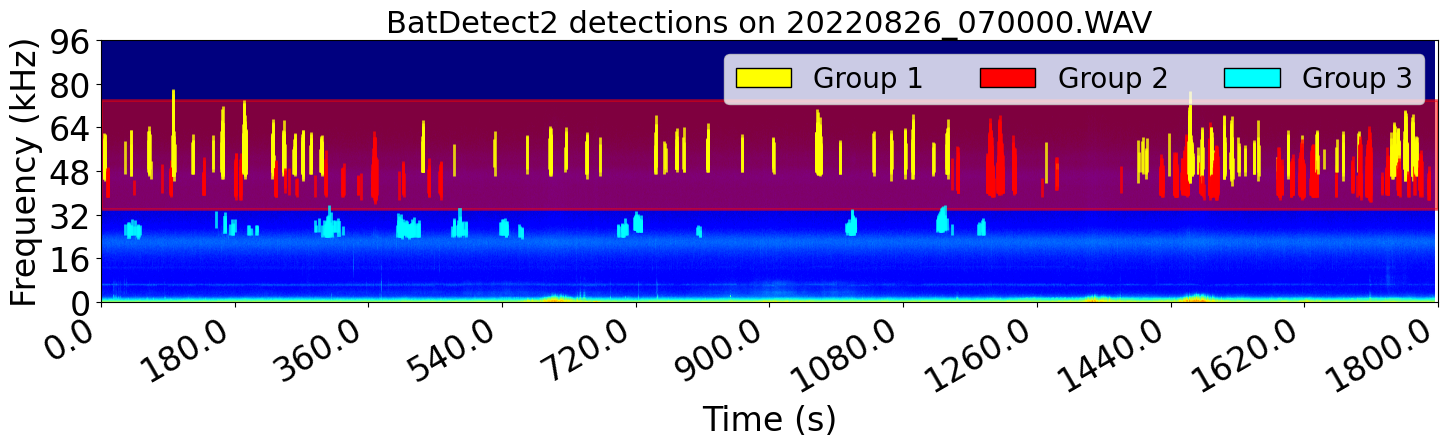

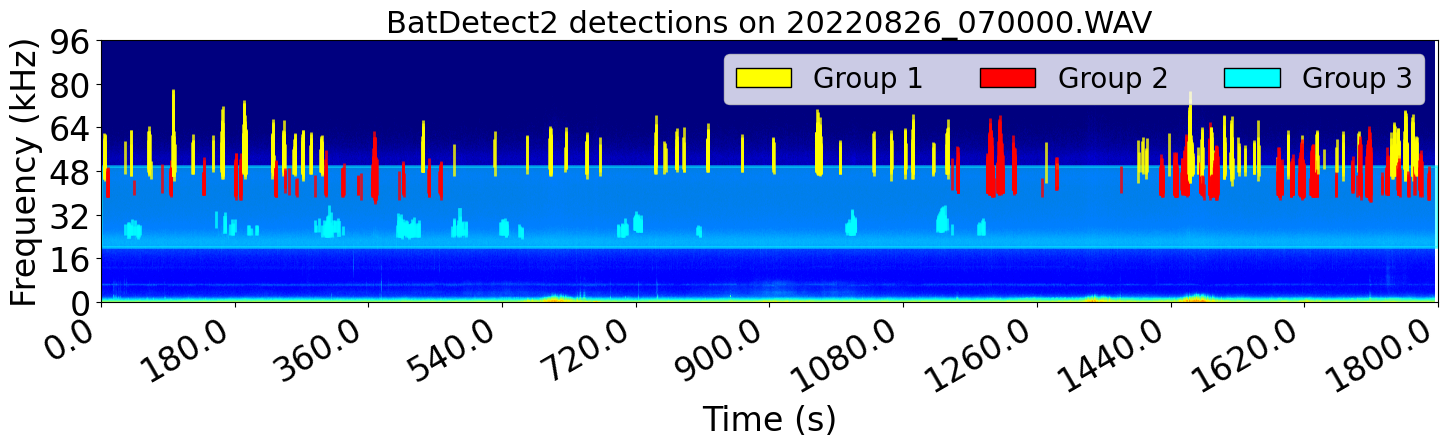

In [9]:
filename = '20220826_070000'
filepath_key = f'UBNA_010/{filename}'
reduce = 55
file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
data_params = dict()
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]
data_params['site_key'] = 'Central'
data_params['site_name'] = SITE_NAMES[data_params['site_key']]
spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)

for start in np.arange(0, 1800, 1800):
    duration = 1800
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB
    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration
    spec_features['vmin'] = vmin
    plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]
    plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, 'yellow')
    plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, 'red')
    plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, 'blue')